# Analysis of meausrements from pegboards

In [1]:
import pandas as pd
import numpy as np
import itertools
import scipy.stats as st 

# Import visualization tools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
mpl.rcParams['figure.dpi'] = 100 # bigger figures, yayy!

# Import packages for statistics
import scipy.stats as sst

import sys
sys.path.append('..')

plt.style.use('ggplot')

# converters
def id2type(id):
    vrtype = id[0:2]
    if vrtype == "PC":
        return "Cave"
    elif vrtype == "PP":
        return "PC"
    elif vrtype == "PO":
        return "Oculus"
    elif vrtype == "PK":
        return "Control"
    
def mm_ss2sec(t):
    if ":" in t:
        ts = t.split(":")
        return int(ts[0]) * 60 + int(ts[1])
    else:
        return int(t) * 60


Load and preprocess data.

In [2]:
rawdf = pd.read_csv('../data/vr_peg_measurements.csv',encoding='utf-8')
# rawdf = rawdf[~((rawdf.iloc[:, 1].isnull())| (rawdf.iloc[:, 2].isnull()))]

In [3]:
# create cleaner dataframe with data from pegboard, maybe skip this step
col_names = ['before VR', 'after VR']
sub_col_names = ['left 1', 'left 2', 'right 1', 'right 2']
frames = {'before VR': (3, 7), 'after VR': (7, 11)}

header = list(itertools.chain.from_iterable(itertools.repeat(x, len(sub_col_names)) for x in col_names))
subheader = list(itertools.chain.from_iterable(itertools.repeat(sub_col_names, len(col_names))))

pegdf = pd.DataFrame(columns=[header, subheader])

for h_id, (start, end) in frames.iteritems():
    for s_id, idx in enumerate(range(start, end)):
        pegdf[h_id, sub_col_names[s_id]] = rawdf[rawdf.columns[idx]]
pegdf.drop(pegdf.index[0], inplace=True)

In [4]:
# create cleaner dataframe with data from VR
vrdf = rawdf[rawdf.columns[[0,1,2]]].copy()
vrdf.columns = (vrdf.iloc[0])
vrdf.drop(vrdf.index[0], inplace=True)

In [5]:
# overlap frames for left and right hand to get rid of NaNs 
# and create dataset with dominant hand data
left_before = pegdf['before VR'][["left 1", "left 2"]]
left_before.columns = (1, 2)
right_before = pegdf['before VR'][["right 1", "right 2"]]
right_before.columns = (1, 2)
dom_before = left_before.fillna(right_before).astype(float)

left_after = pegdf['after VR'][["left 1", "left 2"]]
left_after.columns = (1, 2)
right_after = pegdf['after VR'][["right 1", "right 2"]]
right_after.columns = (1, 2)
dom_after = left_after.fillna(right_after).astype(float)

In [6]:
# create dataframe with compiled data from pegboard and VR
# for easier manipulation
df = pd.DataFrame()
# columns=[["VR","VR","VR","before VR","before VR","after VR", "after VR"],
#                            ["ID", "count", "time", "1", "2", "1", "2"]])
df["ID"] = vrdf["ID"]
df["VRID"] = vrdf["ID"].apply(id2type)
# df["count"] = vrdf["count"].astype(int)
# df["time"] = vrdf["time (min)"].apply(mm_ss2sec)

# take average pegboard time - is it ok or should we take best maybe?
df["before VR"] = np.average(dom_before, axis=1)
df["after VR"] = np.average(dom_after, axis=1)

In [7]:
df.to_csv("../outputs/peg_df.csv", sep=";")

## Dataframe summary

In [8]:
df.groupby("VRID").describe(percentiles=[.5]).round(2)

after VR                                  before VR               \
           count   mean   std   min    50%    max     count   mean   std   
VRID                                                                       
Cave        23.0  55.84  6.46  45.8  54.70  72.50      23.0  60.72  7.40   
Control     21.0  54.12  5.79  45.8  52.25  67.05      21.0  60.55  7.36   
Oculus      24.0  55.67  7.23  44.8  53.80  74.60      24.0  59.83  6.97   
PC          21.0  55.16  4.94  48.6  53.30  66.35      21.0  60.15  6.91   

                              
           min    50%    max  
VRID                          
Cave     50.55  58.20  80.35  
Control  49.00  59.60  75.30  
Oculus   50.25  58.78  75.70  
PC       47.45  58.20  76.40

In [9]:
# melt data for pegboard boxplot
ddb = df.iloc[:,:-1].rename(columns={"before VR": "peg time"})
ddb["order"] = "Before"

dda = pd.concat((df.iloc[:,:-2], df.iloc[:,-1]), axis=1).rename(columns={"after VR": "peg time"})
dda["order"] = "After"
dda
dd=pd.concat((ddb,dda))

## Boxplot!

C:\Anaconda2\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


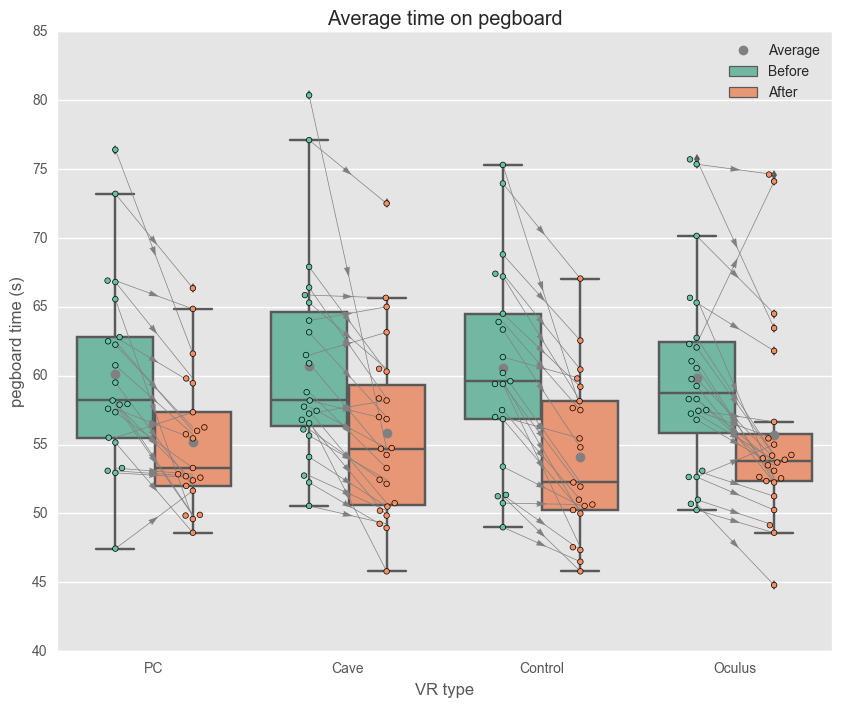

In [10]:
fig, ax = plt.subplots()
sns.boxplot(x="VRID", y="peg time", hue="order", data=dd, ax=ax, palette="Set2")
sns.swarmplot(x="VRID", y="peg time", hue="order", data=dd, ax=ax, 
              palette="Set2", edgecolor="Black", size=4, linewidth=.5, split=True)

Xs = np.repeat(np.atleast_2d(np.arange(6)),2, axis=0) + np.array([[-.2],[.2]])
for vrid, i in zip(dd.VRID.unique(), range(len(dd.VRID.unique()))):
    n = len(dd[(dd.VRID == vrid) & (dd.order == "Before")])
    X = Xs[:, i][:, None] * np.ones((2, n))
    Y = np.array([dd[(dd.VRID == vrid) & (dd.order == "Before")]["peg time"], 
                  dd[(dd.VRID == vrid) & (dd.order == "After")]["peg time"]])
    avrgY = np.mean(Y, axis=1)
    ax.plot(Xs[:,i] , avrgY, "o", color="gray", label="Average")
    ax.plot(X, Y, color="gray", lw=.5) # lines
    ax.quiver((X[0, :] + X[1, :])/2, #X
              (Y[0, :] + Y[1, :])/2, #Y
              (X[1, :] - X[0, :]) / np.sqrt((X[1, :] - X[0, :])**2 + (Y[1, :] - Y[0, :])**2), #U
              (Y[1, :] - Y[0, :]) / np.sqrt((X[1, :] - X[0, :])**2 + (Y[1, :] - Y[0, :])**2), #V
             angles="xy",
             scale=75,
             pivot='mid',
             color='grey')

fig.set_size_inches((10,8))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-5:-2], labels[-5:-2], loc="upper right")
ax.set(title="Average time on pegboard", ylabel="pegboard time (s)", xlabel="VR type");

## Normality test

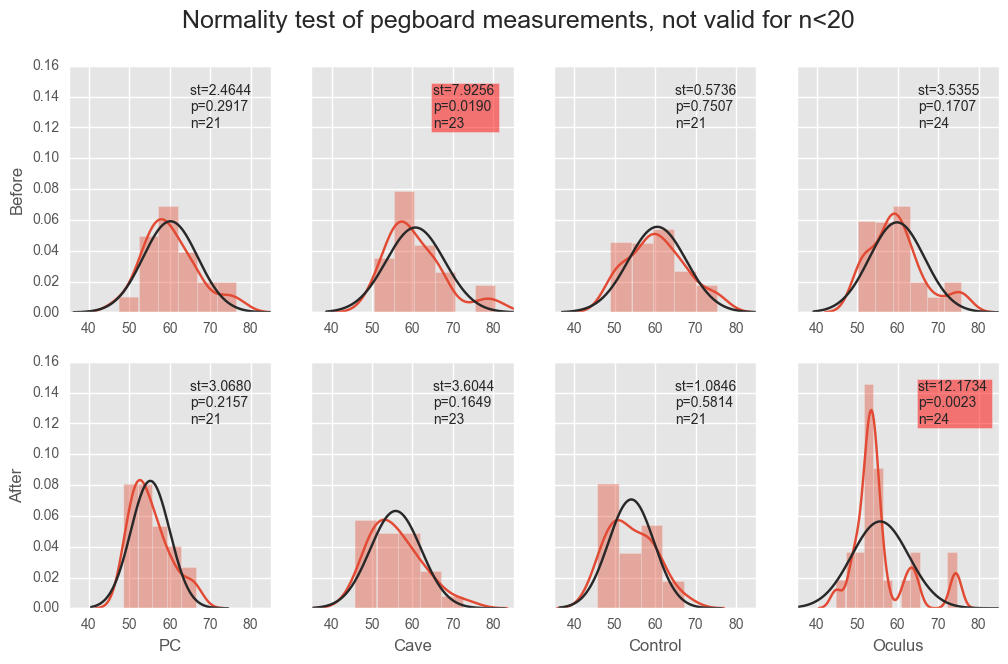

In [11]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12, 7), sharey=True)
fig.suptitle("Normality test of pegboard measurements, not valid for n<20", fontsize=18)

axs[0,0].set_ylabel("Before")
for i, vrid in enumerate(dd.VRID.unique()):
    ax = axs[0, i]
    
    dat = dd[(dd.VRID==vrid) & (dd.order=="Before")]["peg time"]
    ntest = st.normaltest(dat)
    sns.distplot(dat, fit=st.norm, ax=ax)
    
    ax.set_xlim(35, 85)
    ax.set_xlabel("")
    ax.text(ax.get_xlim()[1] - 20,  0.12, 
            ("st=%.4f \np=%.4f" % ntest ) + ("\nn=%d" % len(dat)), 
            bbox={'facecolor':'red', 'alpha':0.5, 'pad':1} if ntest.pvalue < .05 else None)
    
    
axs[1,0].set_ylabel("After")
for i, vrid in enumerate(dd.VRID.unique()):
    ax = axs[1, i]
   
    dat = dd[(dd.VRID==vrid) & (dd.order=="After")]["peg time"]
    ntest = st.normaltest(dat)
    sns.distplot(dd[(dd.VRID==vrid) & (dd.order=="After")]["peg time"], fit=st.norm, ax=ax)
    
    ax.set_xlabel(vrid)
    ax.set_xlim(35, 85)
    ax.text(ax.get_xlim()[1] - 20, 0.12
            , ("st=%.4f \np=%.4f" % ntest ) + ("\nn=%d" % len(dat)), 
            bbox={'facecolor':'red', 'alpha':0.5, 'pad':1} if ntest.pvalue < .05 else None) 
    

## Kruskal-Wallis
Data do not have normal distribution

In [12]:
st.kruskal(*[col for coln, col in dd[dd["order"] == "Before"].groupby("VRID")["peg time"]])

KruskalResult(statistic=0.22262699152054652, pvalue=0.97385642797494709)

Pre-test measurement do not differ, meaning we have homogenous groups and we can compare post-test measurements.

In [13]:
st.kruskal(*[col for coln, col in dd[dd["order"] == "After"].groupby("VRID")["peg time"]])

KruskalResult(statistic=0.78447890235526585, pvalue=0.85317575915035093)

Post-test do not differ either.

### Wilcoxon test of pegboard time pre-test vs post-test

In [114]:
for i, vrid in enumerate(dd.VRID.unique()):\
    print("%s: %s\n" % 
        (vrid, 
        str(st.wilcoxon(dd[(dd.VRID==vrid) & (dd.order=="Before")]["peg time"],
                        dd[(dd.VRID==vrid) & (dd.order=="After")]["peg time"])),))
#         len(vrid), ":",
#         str(st.ttest_rel(dd[(dd.VRID==vrid) & (dd.order=="Before")]["peg time"],
#                          dd[(dd.VRID==vrid) & (dd.order=="After")]["peg time"]))))

PC: WilcoxonResult(statistic=13.0, pvalue=0.00036711724817266051)

Cave: WilcoxonResult(statistic=11.0, pvalue=0.00011214112045483084)

Control: WilcoxonResult(statistic=0.0, pvalue=5.9569779074563588e-05)

Oculus: WilcoxonResult(statistic=29.0, pvalue=0.00054557808647309237)

